In [36]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

In [37]:
# Import necessary libraries
from src.models import LSTModel
import numpy as np
import matplotlib.pyplot as plt
import scipy
import os
from os.path import dirname, join as pjoin
import torch
from torch import nn 
import scipy.signal as signal


# Set data type and device
dtype = torch.float
device = "cuda" if torch.cuda.is_available() else "cpu"
print(torch.cuda.is_available())
#device = torch.device("cpu")

# Close all open plots
plt.close('all')

False


In [38]:
# Load data from file
folderpath = os.getcwd()
filepath = pjoin(folderpath, 'input_5.mat')
data_in = scipy.io.loadmat(filepath)
filepath = pjoin(folderpath, 'output_Q_5.mat')
data_out = scipy.io.loadmat(filepath)


# Extract data from dictionary
dExp, yExp, dExp_val, yExp_val, time__, buildtot, buildtot_val = data_in['dExp'], data_out['yExp'], \
    data_in['dExp_val'], data_out['yExp_val'], data_in['time__'], data_out['buildtotnorm'], data_out['buildtotnorm_val']
nExp = yExp.size


In [39]:
# Create time vector
t = time__

# Set end time
t_end = t.size

# Initialize input and output tensors
u = torch.zeros(nExp, t_end, 3)
y = torch.zeros(nExp, t_end, 2)

# Set input number
inputnumberD = 2

# Fill input and output tensors with data
for j in range(nExp):
    u[j, :, :] = torch.cat(
            (torch.from_numpy(dExp[0, j][:, 3:]),    # Take columns 3 onwards from dExp
            torch.from_numpy(buildtot[j * t_end : (j + 1) * t_end, 0]).unsqueeze(1)),  # Ensure proper shape for buildtot
            dim=-1
        )    
    y[j, :, :] = (torch.from_numpy(yExp[0, j]))
    
    #u[j, :, 4] = torch.from_numpy(signal.medfilt((u[j, :, 4]).numpy(), 15))            # to smooth the input signal of Qhot (noisy)

# Set random seed for reproducibility
seed = 1
torch.manual_seed(seed)

In [ ]:
# Set number of epochs
epochs = 300

# Set dimensions for RNN layers
idd = 3
odd = yExp[0, 0].shape[1]

# Initialize variable to track the smallest loss
best_loss = float('inf')
best_hdd_ldd = None  # To track which hdd, ldd combination gives the best loss

for hdd in [ 200]:  # hdd goes from 10 to 100 (inclusive), step by 10
    for ldd in [1]:
        print(f"Training LSTM with hdd={hdd} and ldd={ldd}")
        
        # Initialize RNN model
        LTS = LSTModel(idd, hdd, ldd, odd)
        
        # Define loss function
        MSE = nn.MSELoss()

        # Define optimization method
        learning_rate = 1.0e-2
        optimizer = torch.optim.Adam(LTS.parameters(), lr=learning_rate)
        optimizer.zero_grad()

        # Initialize array to store loss values
        LOSS = np.zeros(epochs)

        # Train the RNN model
        for epoch in range(epochs):
            # Adjust learning rate at certain epochs
            if epoch == epochs - epochs // 2:
                learning_rate = 1.0e-3
                optimizer = torch.optim.Adam(LTS.parameters(), lr=learning_rate)
            if epoch == epochs - epochs // 6:
                learning_rate = 1.0e-4
                optimizer = torch.optim.Adam(LTS.parameters(), lr=learning_rate)
            
            optimizer.zero_grad()

            # Get RNN output for training data
            yLTS = LTS(u)
            yLTS = torch.squeeze(yLTS)

            # Calculate loss and backpropagate
            loss = MSE(yLTS, y)
            loss.backward()
            optimizer.step()

            # Print loss for the current epoch
            print(f"Epoch: {epoch + 1} \t||\t Loss: {loss.item()}")
            LOSS[epoch] = loss.item()

        # Check if this model has the smallest loss
        final_loss = LOSS[-1]  # Loss at the last epoch
        if final_loss < best_loss:
            best_loss = final_loss
            best_hdd_ldd = (hdd, ldd)
            
            # Save the model parameters with the lowest loss
            torch.save(LTS.state_dict(), 'best_LTS.pth')
            print(f"Best model so far saved with hdd={hdd}, ldd={ldd} and loss={best_loss}")
            
print(f"Training completed. Best model was with hdd={best_hdd_ldd[0]}, ldd={best_hdd_ldd[1]} and loss={best_loss}")

Training LSTM with hdd=150 and ldd=1
Epoch: 1 	||	 Loss: 0.43324339389801025
Epoch: 2 	||	 Loss: 0.18314425647258759
Epoch: 3 	||	 Loss: 2.1034483909606934
Epoch: 4 	||	 Loss: 0.07103721052408218
Epoch: 5 	||	 Loss: 0.1595253199338913
Epoch: 6 	||	 Loss: 0.18130755424499512
Epoch: 7 	||	 Loss: 0.1691799908876419
Epoch: 8 	||	 Loss: 0.12939591705799103
Epoch: 9 	||	 Loss: 0.060878630727529526
Epoch: 10 	||	 Loss: 0.003191412426531315
Epoch: 11 	||	 Loss: 0.08357935398817062
Epoch: 12 	||	 Loss: 0.025258908048272133
Epoch: 13 	||	 Loss: 0.0031157908961176872
Epoch: 14 	||	 Loss: 0.011316979303956032
Epoch: 15 	||	 Loss: 0.02314704842865467
Epoch: 16 	||	 Loss: 0.02915372885763645
Epoch: 17 	||	 Loss: 0.02823856845498085
Epoch: 18 	||	 Loss: 0.022321240976452827
Epoch: 19 	||	 Loss: 0.014349116012454033
Epoch: 20 	||	 Loss: 0.007359914947301149
Epoch: 21 	||	 Loss: 0.0036820790264755487
Epoch: 22 	||	 Loss: 0.0040550148114562035
Epoch: 23 	||	 Loss: 0.007124916650354862
Epoch: 24 	||	 Los

In [41]:
"""
#Set dimensions for RNN layers
idd = u[0,:,:].shape[1] #3
hdd = 10 #7 /10
ldd = 1 #2
odd = yExp[0, 0].shape[1]

# Initialize RNN model
LTS = LSTModel(idd, hdd, ldd, odd)

# Load the model parameters before starting a new training session
LTS.load_state_dict(torch.load('parameters_LSTM_direct.pth'))

# Define loss function
MSE = nn.MSELoss()

# Define optimization method
learning_rate = 1.0e-2
optimizer = torch.optim.Adam(LTS.parameters(), lr=learning_rate)
optimizer.zero_grad()

# Set number of epochs
epochs = 300

# Initialize array to store loss values
LOSS = np.zeros(epochs)
"""

"\n#Set dimensions for RNN layers\nidd = u[0,:,:].shape[1] #3\nhdd = 10 #7 /10\nldd = 1 #2\nodd = yExp[0, 0].shape[1]\n\n# Initialize RNN model\nLTS = LSTModel(idd, hdd, ldd, odd)\n\n# Load the model parameters before starting a new training session\nLTS.load_state_dict(torch.load('parameters_LSTM_direct.pth'))\n\n# Define loss function\nMSE = nn.MSELoss()\n\n# Define optimization method\nlearning_rate = 1.0e-2\noptimizer = torch.optim.Adam(LTS.parameters(), lr=learning_rate)\noptimizer.zero_grad()\n\n# Set number of epochs\nepochs = 300\n\n# Initialize array to store loss values\nLOSS = np.zeros(epochs)\n"

In [42]:
"""
# Train the RNN model
for epoch in range(epochs):
    # Adjust learning rate at certain epochs
    if epoch == epochs - epochs / 2:
        learning_rate = 1.0e-3
        optimizer = torch.optim.Adam(LTS.parameters(), lr=learning_rate)
    if epoch == epochs - epochs / 6:
        learning_rate = 1.0e-4
        optimizer = torch.optim.Adam(LTS.parameters(), lr=learning_rate)
    optimizer.zero_grad()
    loss = 0

    # Get RNN output for training data
    yLTS = LTS(u)
    yLTS = torch.squeeze(yLTS)
    

    # Calculate loss and backpropagate
    loss = MSE(yLTS, y)
    loss.backward()
    optimizer.step()
    

    # Print loss for current epoch
    print(f"Epoch: {epoch + 1} \t||\t Loss: {loss}")
    LOSS[epoch] = loss
    
    # Save model parameters every 15 epochs
    if (epoch + 1) % 15 == 0:
        torch.save(LTS.state_dict(), f'parameters_LSTM_direct.pth')
        print(f"Model parameters saved at epoch {epoch + 1}")
"""

'\n# Train the RNN model\nfor epoch in range(epochs):\n    # Adjust learning rate at certain epochs\n    if epoch == epochs - epochs / 2:\n        learning_rate = 1.0e-3\n        optimizer = torch.optim.Adam(LTS.parameters(), lr=learning_rate)\n    if epoch == epochs - epochs / 6:\n        learning_rate = 1.0e-4\n        optimizer = torch.optim.Adam(LTS.parameters(), lr=learning_rate)\n    optimizer.zero_grad()\n    loss = 0\n\n    # Get RNN output for training data\n    yLTS = LTS(u)\n    yLTS = torch.squeeze(yLTS)\n    \n\n    # Calculate loss and backpropagate\n    loss = MSE(yLTS, y)\n    loss.backward()\n    optimizer.step()\n    \n\n    # Print loss for current epoch\n    print(f"Epoch: {epoch + 1} \t||\t Loss: {loss}")\n    LOSS[epoch] = loss\n    \n    # Save model parameters every 15 epochs\n    if (epoch + 1) % 15 == 0:\n        torch.save(LTS.state_dict(), f\'parameters_LSTM_direct.pth\')\n        print(f"Model parameters saved at epoch {epoch + 1}")\n'

In [43]:
# Save the model parameters after training
torch.save(LTS.state_dict(), 'LSTM_parameters.pth')

In [45]:
# Initialize input and output tensors for validation data
nExp = yExp_val.size
t_end = yExp_val[0, 0].shape[0]
uval = torch.zeros(nExp, t_end, 3)
yval = torch.zeros(nExp, t_end, 2)

# Fill input and output tensors with validation data
for j in range(nExp):
    uval[j, :, :] = torch.cat(
            (torch.from_numpy(dExp_val[0, j][:, 3:]),    # Take columns 3 onwards from dExp
            torch.from_numpy(buildtot_val[j * t_end : (j + 1) * t_end, 0]).unsqueeze(1)),  # Ensure proper shape for buildtot
            dim=-1
        ) 
    yval[j, :, :] = (torch.from_numpy(yExp_val[0, j]))
    #uval[j, :, 4] = torch.from_numpy(signal.medfilt((uval[j, :, 4]).numpy(), 15))

# Get RNN output for validation data
yLTS_val = LTS(uval)
#yLTS_val = yLTS_val.unsqueeze_(0)
print(uval)
# Calculate loss for validation data
loss_val = MSE(yLTS_val, yval)

tensor([[[0.0000, 0.6269, 0.2571],
         [0.0000, 0.6267, 0.2566],
         [0.0000, 0.6270, 0.2569],
         ...,
         [0.0000, 0.5448, 0.2538],
         [0.0000, 0.5448, 0.2216],
         [0.0000, 0.5448, 0.2214]]])


tensor([[[0.0000, 0.6328, 0.2772],
         [0.0000, 0.6569, 0.2770],
         [0.0000, 0.6623, 0.2768],
         ...,
         [0.0000, 0.6250, 0.2363],
         [0.0000, 0.6325, 0.2379],
         [0.0000, 0.5539, 0.2368]]])

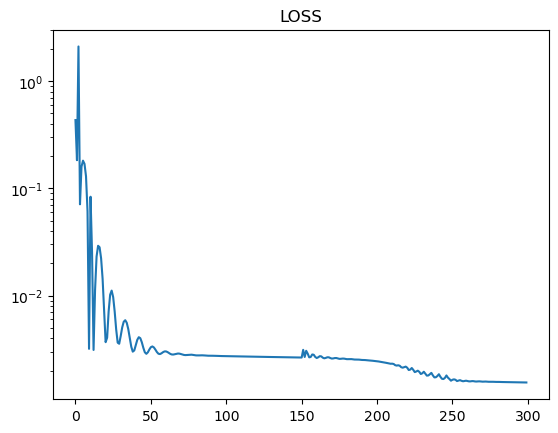

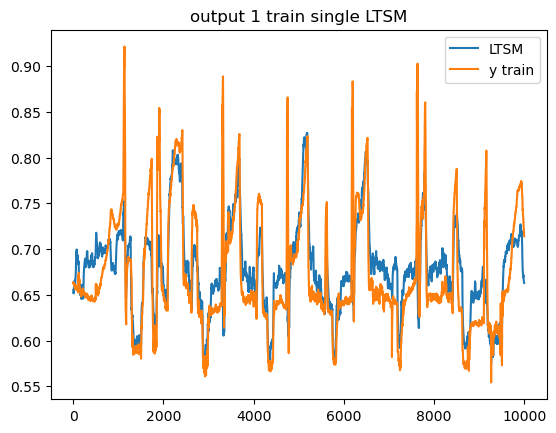

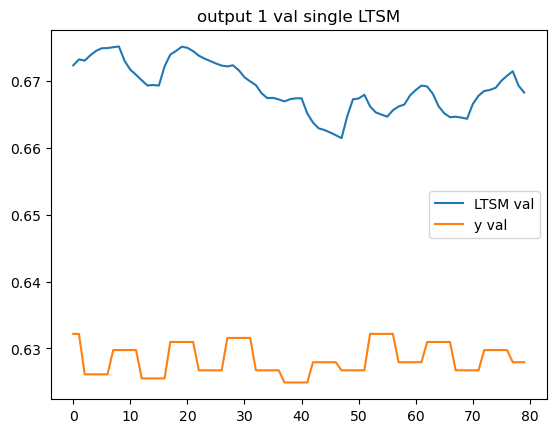

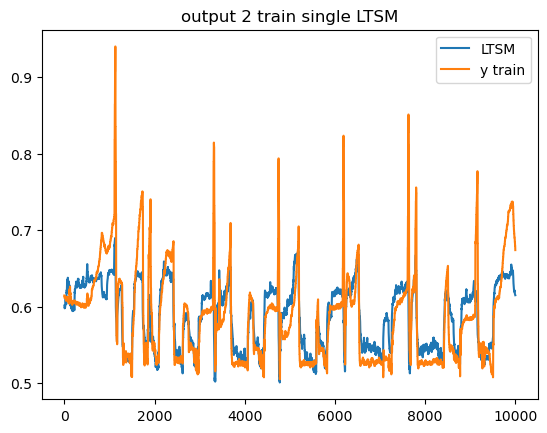

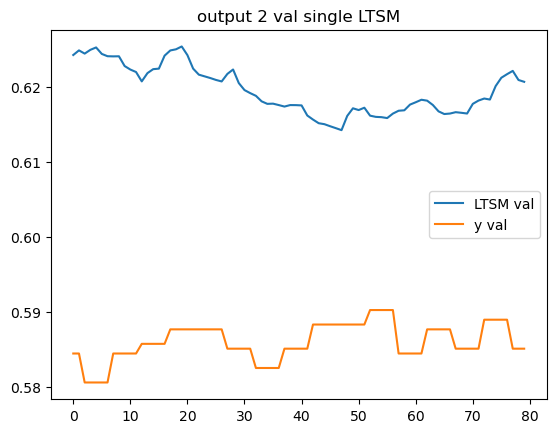

Loss Validation single LTSM: 0.001520827878266573


In [46]:
# Plot loss over epochs
plt.figure('8')
plt.semilogy(LOSS)
plt.title("LOSS")
plt.show()

# Plot output 1 for training data
plt.figure('9')
plt.plot(yLTS[0, 10000:20000, 0].detach().numpy(), label='LTSM')
plt.plot(y[0, 10000:20000, 0].detach().numpy(), label='y train')
plt.title("output 1 train single LTSM")
plt.legend()
plt.show()

# Plot output 1 for validation data
plt.figure('10')
plt.plot(yLTS_val[0, 10000:20000, 0].detach().numpy(), label='LTSM val')
plt.plot(yval[0, 10000:20000, 0].detach().numpy(), label='y val')
plt.title("output 1 val single LTSM")
plt.legend()
plt.show()

# Plot output 2 for training data
plt.figure('11')
plt.plot(yLTS[0, 10000:20000, 1].detach().numpy(), label='LTSM')
plt.plot(y[0, 10000:20000, 1].detach().numpy(), label='y train')
plt.title("output 2 train single LTSM")
plt.legend()
plt.show()

# Plot output 2 for validation data
plt.figure('12')
plt.plot(yLTS_val[0,10000:20000, 1].detach().numpy(), label='LTSM val')
plt.plot(yval[0, 10000:20000, 1].detach().numpy(), label='y val')
plt.title("output 2 val single LTSM")
plt.legend()
plt.show()

# Save RNN output and validation data to file
#scipy.io.savemat('data_singleRNN_sysID_LTSM.mat', dict(yLTSm_val=yLTS_val.detach().numpy(), yval=yval.detach().numpy()))

# Print validation loss
print(f"Loss Validation single LTSM: {loss_val}")

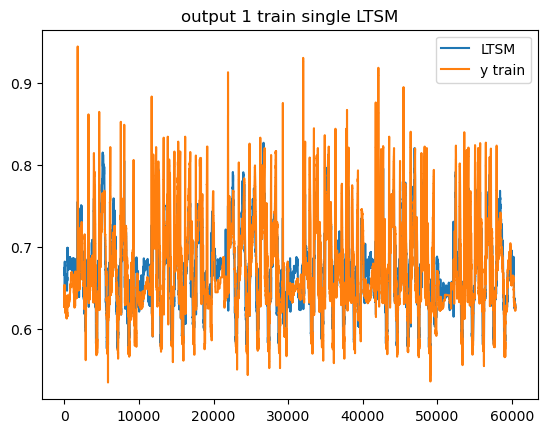

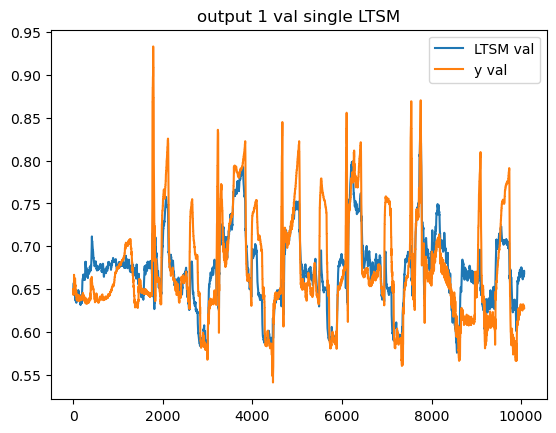

In [47]:
# Plot output 1 for training data
plt.figure('9')
plt.plot(yLTS[1, 10:, 0].detach().numpy(), label='LTSM')
plt.plot(y[1, 10:, 0].detach().numpy(), label='y train')
plt.title("output 1 train single LTSM")
plt.legend()
plt.show()

# Plot output 1 for validation data
plt.figure('10')
plt.plot(yLTS_val[0, 10:, 0].detach().numpy(), label='LTSM val')
plt.plot(yval[0, 10:, 0].detach().numpy(), label='y val')
plt.title("output 1 val single LTSM")
plt.legend()
plt.show()